In [1]:
import pickle
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import lightgbm as lgb
import matplotlib
import japanize_matplotlib
import shap

/Users/itsukikuwahara/Desktop/codes/research/pref_data/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## データの準備

In [74]:
# 全ての年度のデータを結合する関数
def concat_df(df_dict):
    df = pd.concat([df_dict[key] for key in df_dict.keys()])
    return df

In [100]:
# object_df_dictをpickleファイルから読み込む
with open('/Users/itsukikuwahara/Desktop/codes/research/pref_data/object_df_dict.pkl', 'rb') as f:
    object_df_dict = pickle.load(f)
    
with open('/Users/itsukikuwahara/Desktop/codes/research/pref_data/df_young.pkl', 'rb') as f:
    df_young = pickle.load(f)

df_dict = {}

for key in object_df_dict.keys():
    year = str(key) + '年度'
    
    # 若年人口のデータフレームを結合
    temp = df_young[df_young["調査年"]==year][["地域", "若年人口"]]
    merged = pd.merge(object_df_dict[key], temp, on="地域")
    
    # 若年人口割合を算出
    merged["若年人口割合"] = merged["若年人口"] / merged["A1101_総人口【人】"]
    df_dict[key] = merged

# 全ての年度のデータを１つのデータフレームに結合    
df = concat_df(df_dict)

# 東京を外れ値として除外
# df.drop(df[df["地域"]=="東京都"].index, inplace=True)

In [101]:
df_dict[1975]

,調査年,地域,A1101_総人口【人】,A1102_日本人人口【人】,A110201_日本人人口（男）【人】,A110202_日本人人口（女）【人】,B1101_総面積（北方地域及び竹島を除く）【ｈａ】,B1102_総面積（北方地域及び竹島を含む）【ｈａ】,B1103_可住地面積【ｈａ】,B1108_自然環境保全地域面積【ｈａ】,...,E630201_大学学生数（男）【人】,E630202_大学学生数（女）【人】,E8101_在学者1人当たり学校教育費（幼稚園）【円】,E8102_在学者1人当たり学校教育費（小学校）【円】,E8103_在学者1人当たり学校教育費（中学校）【円】,E8104_在学者1人当たり学校教育費（高等学校・全日制）【円】,E8105_在学者1人当たり学校教育費（高等学校・定時制）【円】,E8106_在学者1人当たり学校教育費（特別支援学校）【円】,若年人口,若年人口割合
0,1975年度,北海道,5338206,5330284,2616571,2713713,7851711,8351287,2125043,0.00,...,36528,6154,290917.0,319145.0,385967.0,382151.0,578241.0,3110406.0,3094890,0.579762
1,1975年度,青森県,1468646,1466742,706182,760560,961429,961429,292763,0.00,...,4661,1796,150517.0,304021.0,328902.0,385073.0,468310.0,2919318.0,840194,0.572087
2,1975年度,岩手県,1385563,1383931,667243,716688,1527739,1527739,350496,1679.22,...,4656,1099,180331.0,345271.0,358027.0,378627.0,463636.0,2732975.0,742306,0.535743
3,1975年度,宮城県,1955267,1950790,957778,993012,729094,729094,304654,15449.00,...,25576,8682,190096.0,300635.0,332260.0,423909.0,557421.0,2303817.0,1112795,0.569127
4,1975年度,秋田県,1232481,1231389,589854,641535,1160934,1160934,311205,398.10,...,3426,854,146463.0,338208.0,362654.0,346672.0,515821.0,2850288.0,635562,0.515677
5,1975年度,山形県,1220302,1219429,586417,633012,932611,932611,283985,4748.41,...,3925,1110,141545.0,349295.0,336308.0,401353.0,577705.0,3544897.0,614091,0.503229
6,1975年度,福島県,1970616,1968270,952109,1016161,1378159,1378159,410421,2364.27,...,8068,1390,148408.0,323111.0,328468.0,340309.0,432706.0,2474918.0,1060552,0.538183
7,1975年度,茨城県,2342198,2338151,1157536,1180615,608959,608959,371384,346.13,...,6785,2226,192249.0,305622.0,303728.0,364456.0,498200.0,2423353.0,1330421,0.568022
8,1975年度,栃木県,1698003,1695848,833590,862258,641379,641379,279490,3322.39,...,5327,953,252509.0,297642.0,319115.0,365472.0,420176.0,2270132.0,965276,0.568477
9,1975年度,群馬県,1756480,1753436,857665,895771,635561,635561,224853,3227.03,...,4962,1029,177227.0,286290.0,323026.0,398019.0,476085.0,2127224.0,981392,0.558727


## 変化率を算出

In [112]:
# 増減率を計算した新たなデータフレームを作成し、辞書に保存
def calc_change_rate(dictionary):
    df_change_rate_dict = {}
    year_list = list(dictionary.keys())
    
    for i in range(len(year_list)-1):
        # 対象年と１つ前の年度を取得、辞書のキーを作成
        prev_year = year_list[i]
        year = year_list[i+1]
        year2year = str(prev_year) + "_" + str(year)

        # 対象年と１つ前の年度のデータフレームを取得        
        prev_year_df = dictionary[year_list[i]].iloc[:, 2:]
        year_df = dictionary[year_list[i+1]].iloc[:, 2:]
        area = dictionary[year_list[i]]["地域"]
        
        # 0で割るのを防ぐために全ての列に１を足す
        prev_year_df = prev_year_df + 1
        year_df = year_df + 1
        
        # 変化率を計算
        df_change_rate = (year_df - prev_year_df) / prev_year_df

        # 変化率を計算したデータフレームに地域と調査年を追加
        df_change_rate = pd.concat([area, df_change_rate], axis=1)
        df_change_rate_dict[year2year] = df_change_rate        
        
    return df_change_rate_dict

In [114]:
df_cr_rate = calc_change_rate(df_dict)

In [115]:
df_cr_rate["1975_1976"]

,地域,A1101_総人口【人】,A1102_日本人人口【人】,A110201_日本人人口（男）【人】,A110202_日本人人口（女）【人】,B1101_総面積（北方地域及び竹島を除く）【ｈａ】,B1102_総面積（北方地域及び竹島を含む）【ｈａ】,B1103_可住地面積【ｈａ】,B1108_自然環境保全地域面積【ｈａ】,B1201_評価総地積（課税対象土地）【ｍ2】,...,E630201_大学学生数（男）【人】,E630202_大学学生数（女）【人】,E8101_在学者1人当たり学校教育費（幼稚園）【円】,E8102_在学者1人当たり学校教育費（小学校）【円】,E8103_在学者1人当たり学校教育費（中学校）【円】,E8104_在学者1人当たり学校教育費（高等学校・全日制）【円】,E8105_在学者1人当たり学校教育費（高等学校・定時制）【円】,E8106_在学者1人当たり学校教育費（特別支援学校）【円】,若年人口,若年人口割合
0,北海道,0.010639,0.010828,0.010865,0.010424,0.000014,0.000013,0.000050,3689.670000,-0.001198,...,0.056339,0.087734,-0.014660,0.096852,0.095194,0.144074,0.172369,0.080615,-0.002549,-0.004789
1,青森県,0.010455,0.010403,0.011071,0.008467,0.000034,0.000034,0.000113,223.980000,0.004026,...,0.101244,0.187535,-0.063793,0.093996,0.064521,0.048141,0.174376,0.025183,-0.002611,-0.004706
2,岩手県,0.006811,0.007276,0.008628,0.006017,0.000004,0.000004,0.000017,0.000000,0.003040,...,0.050032,0.080000,0.193271,0.038871,0.036539,0.051195,0.142430,0.097794,-0.007148,-0.004837
3,宮城県,0.014695,0.014973,0.015893,0.014086,0.000010,0.000010,0.000023,0.000000,0.007104,...,0.026821,0.067143,-0.193122,0.071019,0.083552,0.048142,0.068819,0.058359,0.007373,-0.002617
4,秋田県,0.005289,0.005369,0.007029,0.003842,0.000023,0.000023,0.000112,0.000000,0.012092,...,0.114094,0.084211,0.111379,0.141300,0.052367,0.117344,0.180995,0.233491,-0.007178,-0.004219
5,山形県,0.005489,0.005389,0.007815,0.003141,0.000002,0.000002,0.000007,0.000000,0.005667,...,0.046867,0.008101,0.041301,0.133929,0.147760,0.039805,0.229809,-0.042503,-0.003405,-0.002961
6,福島県,0.006792,0.006976,0.008288,0.004762,0.000029,0.000029,0.000097,0.255561,0.006134,...,0.024290,0.081955,0.116300,0.071870,0.107712,0.023205,0.126901,-0.078933,-0.004292,-0.003852
7,茨城県,0.016140,0.016188,0.016815,0.014725,0.000007,0.000007,0.000011,0.563881,0.001330,...,0.159888,0.204311,0.169633,0.096426,0.106635,0.109291,0.025668,0.114251,0.007200,-0.003187
8,栃木県,0.011188,0.011293,0.013688,0.010138,0.000000,0.000000,0.000000,0.000000,-0.000184,...,0.076577,0.001048,0.209243,0.114180,0.029525,0.128253,0.191519,0.066308,0.004894,-0.002256
9,群馬県,0.012252,0.012298,0.013216,0.011419,0.000000,0.000000,0.000000,0.111480,0.002727,...,0.073947,0.031068,0.146348,0.124213,0.119349,0.027240,0.394420,0.393538,-0.000399,-0.004480


## データの分割

In [58]:
y = df["若年人口割合"]
x = df.drop(["若年人口","若年人口割合","地域", "調査年"], axis=1)

train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.2, random_state=0)

## モデルの学習

In [59]:
model = lgb.LGBMRegressor()
model.fit(train_x, train_y)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001782 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 48323
[LightGBM] [Info] Number of data points in the train set: 1278, number of used features: 209
[LightGBM] [Info] Start training from score 0.451852


LGBMRegressor()

## モデルの評価

In [60]:
predict_y = model.predict(test_x)
mse = mean_squared_error(test_y, predict_y)
rmse = np.sqrt(mse)
r2 = r2_score(test_y, predict_y)

print(f"mse : {mse}, rmse : {rmse}, r2 : {r2}")

mse : 6.443272979498403e-05, rmse : 0.008027000049519374, r2 : 0.982407504837721


## 特徴量重要度を可視化

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

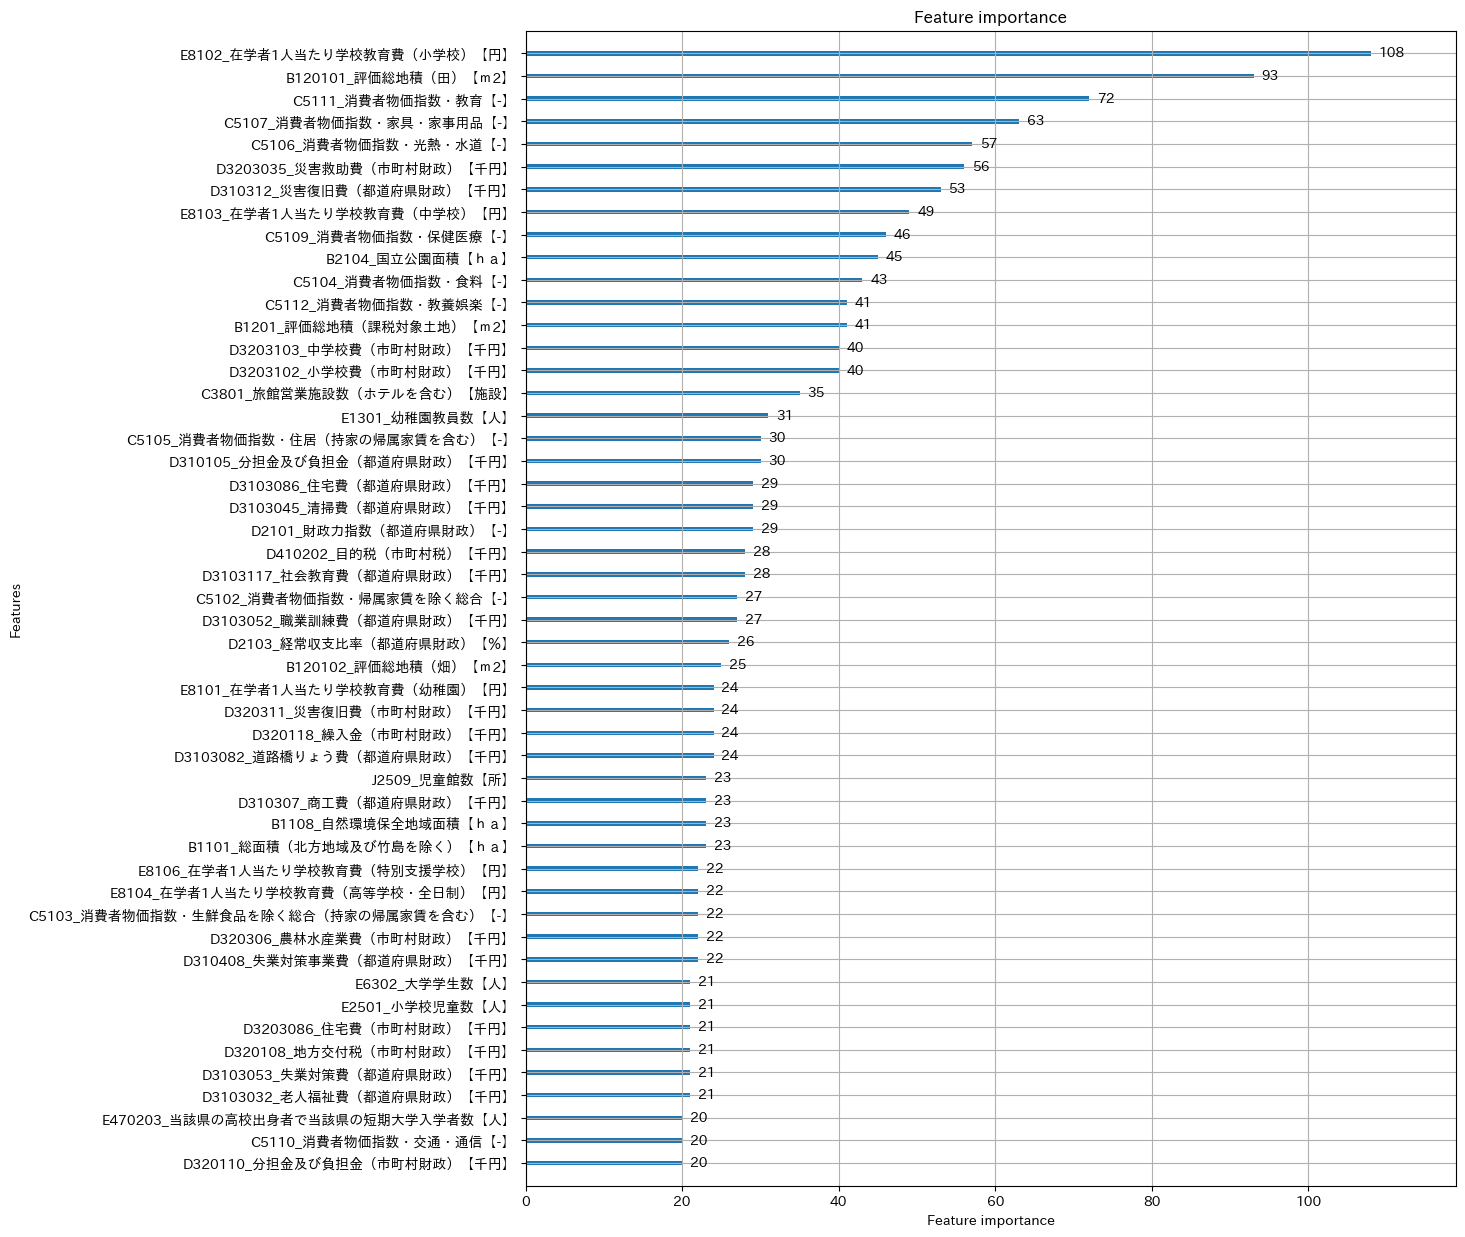

In [61]:
lgb.plot_importance(model, figsize=(12, 15), max_num_features=50)

## SHAPを利用した重要度分析

In [62]:
explainer = shap.Explainer(model)
shap_values = explainer(test_x)

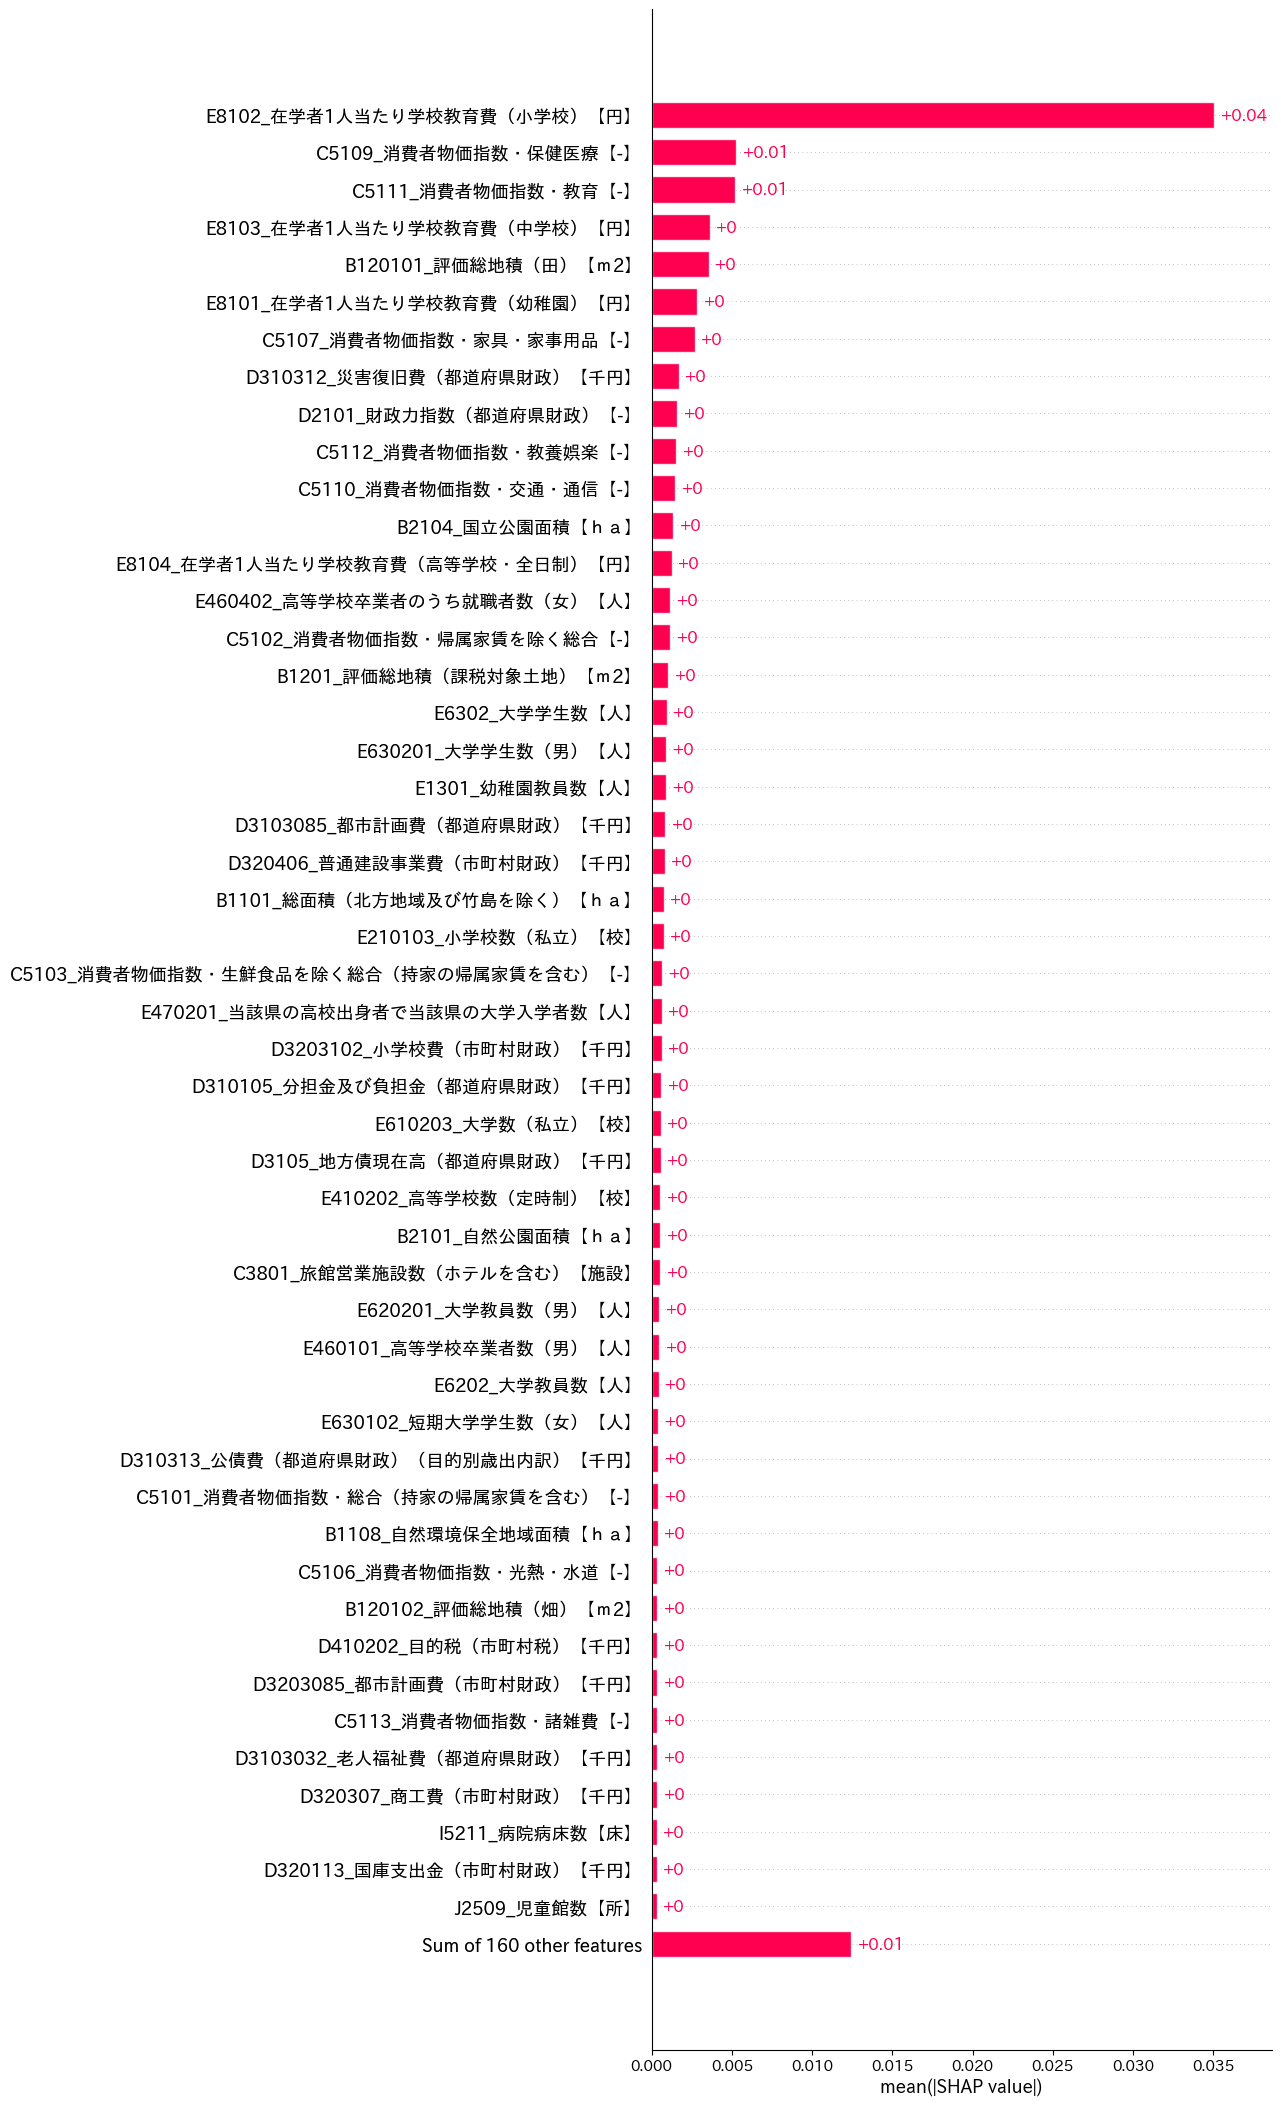

In [63]:
shap.plots.bar(shap_values, max_display=50)

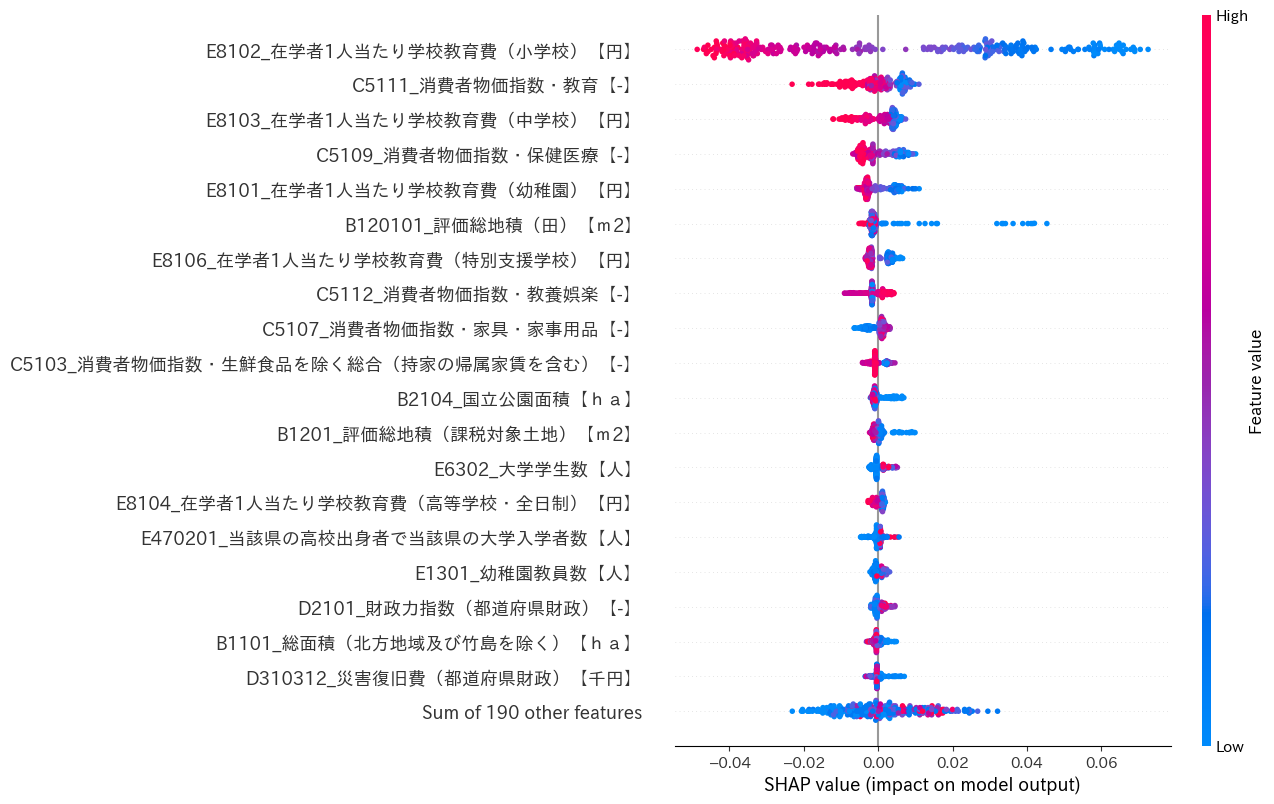

In [45]:
shap.plots.beeswarm(shap_values, max_display=20)